# Non parametric Model 

* V&M (2011) HB + ACs

In [132]:
%autosave  50000

Autosaving every 50000 seconds


In [133]:
import numpy as np; import matplotlib.pyplot as plt
import pymc3 as pm; from scipy import stats; import pandas as pd ;import os 
import theano; import seaborn as sns; from theano import shared, tensor as tt
# Age, Age Error, 40Ar, 39Ar, 37Ar, 36Ar, Temperature
cwd = os.chdir("/Users/jackcarter/Blind_Mixture_Data")
df = pd.read_csv("mix_hb_acs_yy.csv", engine = 'python')

In [134]:
from scipy import stats
from pymc3.distributions import draw_values
from pymc3.distributions import generate_samples
from pymc3.theanof import floatX
from pymc3.distributions.dist_math import bound
from pymc3.distributions import (Continuous, draw_values, generate_samples)

def assert_negative_support(var, label, distname, value=-1e-6):
    # Checks for evidence of positive support for a variable
    if var is None:
        return
    try:
        # Transformed distribution
        support = np.isfinite(var.transformed.distribution.dist
                              .logp(value).tag.test_value)
    except AttributeError:
        try:
            # Untransformed distribution
            support = np.isfinite(var.distribution.logp(value).tag.test_value)
        except AttributeError:
            # Otherwise no direct evidence of non-positive support
            support = False

    if np.any(support):
        msg = "The variable specified for {0} has negative support for {1}, ".format(
            label, distname)
        msg += "likely making it unsuitable for this parameter."
        warnings.warn(msg)

def get_tau_sigma(tau=None, sigma=None):
    if tau is None:
        if sigma is None:
            sigma = 1.
            tau = 1.
        else:
            tau = sigma**-2.
    else:
        if sigma is not None:
            raise ValueError("Can't pass both tau and sigma")
        else:
            sigma = tau**-.5
    tau = 1. * tau
    sigma = 1. * sigma
    return floatX(tau), floatX(sigma)

In [135]:
class weighted_Normal(pm.distributions.Continuous):

    def __init__(self, mu=0, sigma=None, tau=None, sd=None, weight =None,**kwargs):
        if sd is not None:
            sigma = sd
        tau, sigma = get_tau_sigma(tau=tau, sigma=sigma)
        self.sigma = self.sd = tt.as_tensor_variable(sigma)
        self.tau = tt.as_tensor_variable(tau)
        self.weight = tt.as_tensor_variable(weight)

        self.mean = self.median = self.mode = self.mu = mu = tt.as_tensor_variable(floatX(mu))
        self.variance = 1. / self.tau

        assert_negative_support(sigma, 'sigma', 'Normal')
        assert_negative_support(tau, 'tau', 'Normal')

        super().__init__(**kwargs)

    def random(self, point=None, size=None):
        
        mu, tau, _ = draw_values([self.mu, self.tau, self.sigma],
                                 point=point, size=size)
        return generate_samples(stats.norm.rvs, loc=mu, scale=tau**-0.5,
                                dist_shape=self.shape,
                                size=size)

    def logp(self, value):
        """
        Sum of Squares
        
        """
        sigma = self.sigma
        tau = self.tau
        mu = self.mu
        weight = self.weight
        
        logp = - weight * tt.sqr(value - mu)/(2.0 * sigma * sigma)
        return  logp.sum()


In [136]:
df.tail()

,Age,Age Error,40Ar_r,39Ar,39Ar_err,37Ar,36Ar,temp,Da2,Da2_err,Kca,Kca_err
38,1.42,0.087474,0.284115,0.509262,0.000043,0.001362,0.000433,1030.140095,0.000095,9.190000e-10,160.727,58.174103
39,1.25,0.099639,0.202711,0.411542,0.000042,0.002098,0.000378,1040.089334,0.000103,7.790000e-10,84.366,21.051951
40,1.36,0.111156,0.180873,0.339815,0.000036,0.002230,0.000261,1049.806273,0.000118,5.130000e-10,65.512,17.505821
41,1.38,0.109136,0.367424,0.677311,0.000040,0.006512,0.001031,1109.363413,0.000614,1.240000e-09,44.727,4.782669
42,1.62,0.294296,0.083795,0.131393,0.000025,0.000116,0.000392,1229.093815,inf,1.250000e-09,487.708,2343.976294


In [137]:
# Age 
age = df['Age'].values
data = age
age_err = df['Age Error'].values
age_m = age
N = age.shape[0]
age = data[data > 0]
ar39 = df['39Ar'].values

In [138]:
da2 = df['Da2'].values
da2_err = df['Da2_err'].values
temp = df['temp'].values
time = np.ones(len(temp))*300
tempk = temp + 273.15

In [139]:
tplot = 1e4/(tempk)
def cumrel(x): 
    y = np.cumsum(x)
    z = y/y.max()
    return z
x_plot  = cumrel(ar39)

In [140]:
x_plot2 = np.insert(x_plot, 0, 0)

age_plot = np.insert(age, 0, age[0])

age_err_plot = np.insert(age_err, 0, age_err[0])

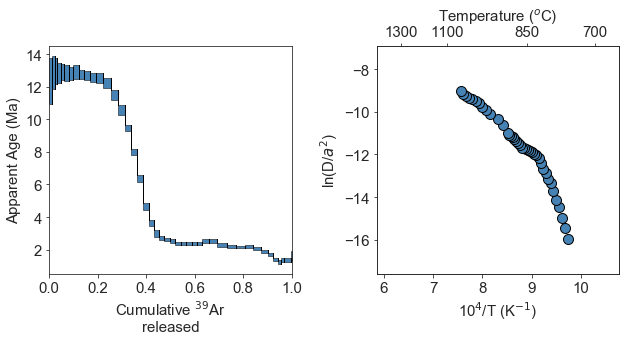

In [141]:
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 15}

plt.rc('font', **font)
sns.set_style('ticks')


fig,ax = plt.subplots(1,2, figsize = (9,5))


ax[0].fill_between(x_plot2, 
                  age_plot - age_err_plot, 
                  age_plot + age_err_plot, 
                  facecolor = 'steelblue', 
                  edgecolor = 'k',
                  step = 'pre',
                  lw = 0.5)

ax[0].set_ylabel('Apparent Age (Ma)')
ax[0].set_xlabel('Cumulative $^{39}$Ar\nreleased');
ax[0].set_xlim(0,1)



for i in range(len(x_plot)): 
    ax[0].vlines(x_plot, age - age_err, 
              age + age_err, 
              color = 'k',
                lw = 0.5)


ax[1].plot(tplot[1:-2], np.log(da2[1:-2]), 'o', 
          markerfacecolor = 'steelblue', 
          markeredgecolor = 'k', 
          markersize = 10)
ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax[1].set_ylabel('ln(D/$a^{2}$)')

ax2 = ax[1].twiny()

Tdc = np.array([700,  850, 1100,  1300])
Tp = 10e3/(Tdc + 273.15)
labels = list(['700', '850', '1100',   
              '1300'])
ax2.plot(tplot, np.log(da2), alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax[1].set_xlim(Tp.min() - 0.5, Tp.max()+ 0.5)
ax2.set_xlim(Tp.min() - 0.5, Tp.max()+ 0.5)
ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)

plt.tight_layout()


In [142]:
"""
Data for Model
"""

from theano import shared, tensor as tt
age_data = shared(age)
age_data_err = shared(age_err)

arr_data = shared(np.log(da2))
arr_err_data = shared((da2_err/2)/da2)
tempk = tempk
time = time

In [143]:
def inc_mdd(ea, d0, a,phi,temp, t):
    R = 8.314e-3
    D0t = ((phi/a)**2)* d0 * np.exp(-ea/(R*temp))*t
    q = (6./(np.pi**(3/2)))*np.sqrt((np.pi**2)*D0t)
    aa1 = np.sqrt(np.pi) * a**2 * R * temp**2
    bb1 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    dd1 = 3 * d0 * ea * t * phi**2
    z1 = (dd1 * np.exp(-ea/(R*temp)))/(aa1 * np.sqrt(bb1))
    aa2 = a**2 * R *temp**2
    bb2 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    cc1 = 3 * d0 * ea * t * phi**2 * np.exp(-ea/(R*temp))
    z2 = cc1/(np.sqrt(np.pi) * aa2 * np.sqrt(bb2)) - cc1/(aa2) 
    aa3 = a**2 * R * temp**2
    bb3 = (phi/a)**2 * d0*np.exp(-ea/(R*temp))*t
    cc2 = 6 * d0 * ea * t * phi**2
    z3 = (cc2 * np.exp(-(np.pi**2 * bb3) - (ea/(R*temp)))/(aa3))
    Q = tt.switch(q <= 0.9,
                z2,
                 z3)
    T = tt.switch(q < 0.1, 
                  z1,
                  Q)
    return T

In [212]:
"""
Stick Breaking 
"""
import pymc3.distributions.transforms as tr
from theano import tensor as tt
def stick_break(beta): 
    pr = tt.concatenate([[1], 
                         tt.extra_ops.cumprod(1 - beta)[:-1]])
    return beta * pr

In [213]:
"""
Truncated Maximum number of components 
"""
k = 20

"""
Truncated Maximum number of domains
"""
m = 10
"""
MODEL START
"""
N = 38 
tempk = tempk[:N]
time = time[:N]
Q = pm.Model()
with Q: 
    """
    Global Number of Component 
    """
    alpha = pm.Gamma('alpha', 
                         1., 1)

    beta = pm.Beta('beta', 1., alpha, 
                      shape = k, 
                  testval = 0.8)

    K_w = stick_break(beta)
    
    K = pm.Deterministic('K', 
            K_w/K_w.sum(axis = 0,
                keepdims = True))
    
    C = pm.Categorical('C', 
                       p = K,
                       shape = (N,))
    
    """
    Number of Domains per component
    """

    phi = pm.Dirichlet('phi', 
                       a = np.ones(m), 
                      shape = (k,m))
    
    D = pm.Categorical('D', 
                       p = phi[C], 
                       shape = N)

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [214]:
import pymc3.distributions.transforms as tr

with Q: 
    """
    Diffusion Kinetics
    - Activation energy 
    - Frequency Factor
    - With Hyperparameters
    """
    ea_mean = pm.Uniform('ea_mean',
                      lower = 80, 
                      upper = 500, 
                      shape = k, 
                        testval = 220)
    
    ea_sd = pm.HalfNormal('ea_sd',
                      sd = ea_mean/10, 
                      shape = k)
    
    Ea = pm.Normal('Ea',
                      mu = ea_mean, 
                      sd = ea_sd, 
                      shape = k)
    
    d0_mean = pm.Uniform('d0_mean',  
                      lower = 0,  
                      upper = 10000,
                      shape = k, 
                        testval = 2)
    
    d0_sd = pm.HalfNormal('d0_sd',  
                      sd = d0_mean/10, 
                      shape = k)
        
        
    d0 = pm.Normal('d0',  
                      mu = d0_mean, 
                      sd = d0_sd,
                      shape = k)
    
    pm.Potential('Ea_constraint',
                tt.switch(Ea < 80, 
                         -np.inf, 0) + 
                tt.switch(Ea > 500, 
                         -np.inf, 0) +  
                tt.switch(d0 < 0, 
                        -np.inf, 0) + 
                tt.switch(d0 > 10000, 
                         -np.inf, 0))


In [215]:
with Q: 
    """
    Grain size and/or domain size
    """
    a = pm.Uniform('a', lower = 0.00001, 
                  upper = 0.0063/2, 
                  shape = (k,m), 
                  testval = 0.003)

In [216]:
with Q: 
    """
    Age Prior 
    with mean and standard deviation 
    hyperparameters
    """
    
    age_mean = pm.Uniform('age_mean',
                          lower = 0.0,
                          upper = 4600,
                              shape = k,
                         testval = data.mean())
    
    age_sd = pm.HalfNormal('age_sd', 
                          sd = age_mean/10,
                          shape = k)
    
    age_model = pm.Normal('age_model', 
                          mu = age_mean, 
                         sd = age_sd, 
                         shape = k)
    
    pm.Potential('age_con', 
                tt.switch(age_model < 0, 
                         -np.inf, 0)+ 
                tt.switch(age_model > 4600, 
                         -np.inf, 0))

In [217]:
with Q: 
    """
    Indexing all the parameters
    """
    age_comp = pm.Deterministic('age_comp',
                                age_model[C])
    ea_comp = pm.Deterministic('ea_comp',
                               Ea[C])
    d0_comp = pm.Deterministic('d0_comp',
                               d0[C])
    phi_comp = pm.Deterministic('phi_comp',
                                K[C])
    a_domain = pm.Deterministic("a_domain",
                                a[C,D])
    phi_domain = pm.Deterministic('phi_domain',
                                  phi[C,D])

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [218]:
with Q: 
    """
    Age Model
    """

    Z2 = K[C] * inc_mdd(Ea[(C)], 
                d0[(C)], 
                a[(C,D)], 
                phi[(C,D)],
                tempk[:,None],
                time[:,None])
    
    Y_sum2 = Z2.sum(axis = 1)
    
    XX = (Z2 * age_model[C]).sum(axis = 1)

    mu2 = (XX/Y_sum2)

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


In [219]:
with Q: 
    """
    Incremental Release Trace
    """
    inc_rel = pm.Deterministic('inc_rel', Y_sum2)

In [220]:
with Q:
    """
    Arrhenius Model 
    """
    R = 8.314e-3

    y2 = ((((phi[(C,D)]/a[(C,D)])**2) \
                 * d0[(C)] * np.exp(-Ea[(C)]/(R*tempk))))
    
    yy2 = (K[C] * y2)
    
    mu1 = tt.log(yy2)


/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


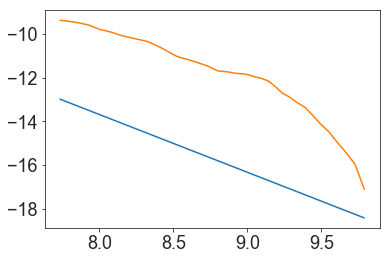

In [221]:
"""
Arrhenius plots
"""
plt.plot(tplot[:N], mu1.tag.test_value[:N])
plt.plot(tplot[:N], arr_data.eval()[:N])


In [222]:
"""
Calculate Model weights
"""
def logp_w(data, model, err): 
    y =   - ((data - model)**2)/(2*err * err)
    return y.sum()

y1_test = mu2.tag.test_value
y2_test = mu1.tag.test_value

with Q: 

    y1 = logp_w(data[:N], 
                mu2.tag.test_value,
                age_err[:N])
    
    y2 = logp_w(arr_data[0:N], 
               mu1.tag.test_value,
                arr_err_data[0:N])

    
    weight = y1/y2

In [223]:
1/weight.eval()

20984021.00016088

In [224]:
with Q: 
    """
    Arrhenius Likelihood
    """
    obs2 = weighted_Normal('obs2', mu1[:N],
                     arr_err_data[:N], 
                     observed = arr_data[:N], 
                           weight = weight)

In [225]:
with Q: 
    """
    Age Likelihood
    """
    obs1 = weighted_Normal('obs1', mu = mu2[:N], 
                           sd = age_data_err[:N], 
                           observed = age_data[:N], 
                          weight = 1)

In [226]:
Q.check_test_point()

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


alpha_log__               -1.00
beta_logodds__           -36.65
C                         -8.48
phi_stickbreaking__     -204.48
D                        -87.50
ea_mean_interval__       -30.08
ea_sd_log__              -15.40
Ea                       -75.68
d0_mean_interval__      -170.35
d0_sd_log__              -15.40
d0                        18.33
a_interval__            -618.06
age_mean_interval__     -132.05
age_sd_log__             -15.40
age_model                 -4.46
obs2                  -16939.76
obs1                  -16939.76
Name: Log-probability of test_point, dtype: float64

In [262]:
SAMPLES = 100000
BURN = 700000
SEED = np.random.seed(123)

with Q:
    step1 = pm.CategoricalGibbsMetropolis([C,D]) 

    
    step2 = pm.Metropolis([age_mean, age_sd,
                           Ea, d0, 
                           d0_sd, d0_mean,
                           ea_mean, ea_sd,
                           age_model], 
                         scaling = 100)
    
    step3 = pm.Metropolis([alpha, beta, 
                          phi, a])
                
    trace = pm.sample(SAMPLES, tune = BURN, 
                     step = [step1,
                             step2, 
                            step3],
                     random_seed = SEED)


Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>CategoricalGibbsMetropolis: [D, C]
>CompoundStep
>>Metropolis: [age_model]
>>Metropolis: [ea_sd]
>>Metropolis: [ea_mean]
>>Metropolis: [d0_mean]
>>Metropolis: [d0_sd]
>>Metropolis: [d0]
>>Metropolis: [Ea]
>>Metropolis: [age_sd]
>>Metropolis: [age_mean]
>CompoundStep
>>Metropolis: [a]
>>Metropolis: [phi]
>>Metropolis: [beta]
>>Metropolis: [alpha]
/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
Sampling 2 chains: 100%|██████████| 1600000/1600000 [21:47:41<00:00, 20.39draws/s]      
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estim

Text(0, 0.5, 'Mixture Weight')

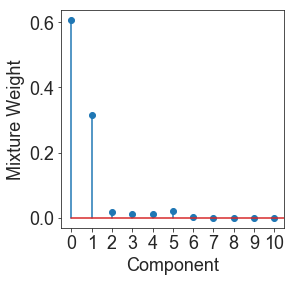

In [263]:
SAMPLES = 50000
plt.figure(figsize = (4,4))
plt.stem(trace['K'][-SAMPLES:].mean(axis=0));
plt.xticks(range(20));
plt.xlim(-0.5, 10.5)
plt.xlabel('Component')
plt.ylabel('Mixture Weight')

In [264]:
SAMPLES = 5000

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


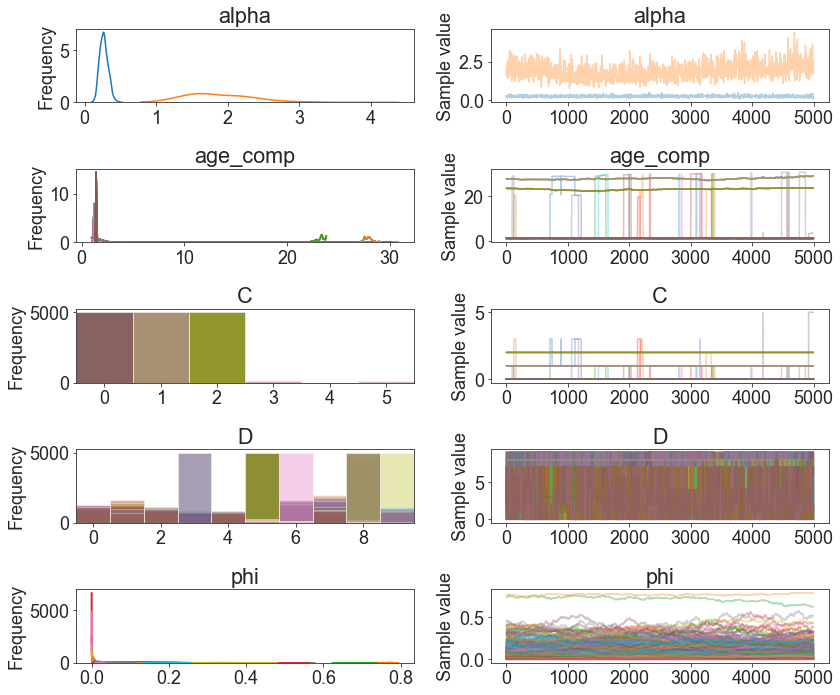

In [265]:
pm.traceplot(trace[-SAMPLES:], varnames =  [alpha, 
                             age_comp, 
                             C, 
                             D, 
                             phi]); 

/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])


Text(0, 0.5, 'Log probability')

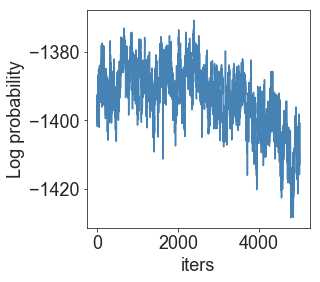

In [266]:
"""
Trace of Logp
"""

logp_model = Q.logp
logp = [logp_model(i) for i in trace[-SAMPLES:]]
logp_x = np.array([logp])
logp_x = logp_x.reshape(SAMPLES)

"""
Plot
"""
plt.figure(figsize = (4,4))
plt.plot(logp_x,
        color = 'steelblue')
plt.xlabel('iters')
plt.ylabel('Log probability')

In [267]:
SAMPLES = 50000

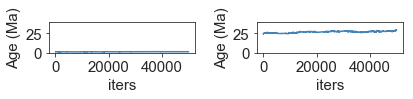

In [303]:
n_comp = np.apply_along_axis(lambda x: np.unique(x).size, 
                            1, trace['C'][-SAMPLES::10])

n_comp =  n_comp 
ncmp = n_comp.mean(axis = 0).astype(int)
plt.figure(figsize = (ncmp*3, ncmp*0.75))
for i in range(ncmp):
    plt.subplot(1,ncmp,i+1)
    plt.plot(trace['age_model'][-SAMPLES:][:,i],
        color = 'steelblue')

    plt.xlabel('iters')
    plt.ylabel('Age (Ma)')
    plt.ylim(0,40)
plt.tight_layout()

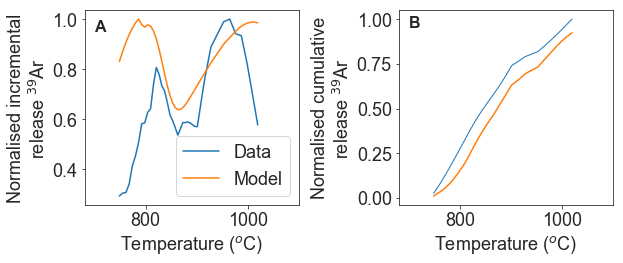

In [269]:
ar39 = df['39Ar'].values
inc_model = trace['inc_rel'].mean(axis = 0)
frel_model = cumrel(inc_model)

inc_model_low, inc_model_high = np.percentile(trace['inc_rel'], 
                                              [50 - 34, 50 + 34], 
                                             axis = 0)
frel_model_low = cumrel(inc_model_low)
frel_model_high = cumrel(inc_model_high)
yy = frel_model_low - frel_model_high

fig,ax = plt.subplots(1,2, figsize = (9, 4))
ax[0].plot(temp[:N],
         ar39[:N]/ar39[:N].max(), 
          label = 'Data')
ax[0].plot(temp[:N], 
         trace['inc_rel'].mean(axis = 0)/trace['inc_rel'].mean(axis = 0).max(), 
          label = 'Model')
ax[0].set_ylabel('Normalised incremental\nrelease $^{39}$Ar')
ax[0].set_xlabel('Temperature ($^{o}$C)')
ax[1].plot(temp[:N], frel_model, lw = 1)
ax[1].plot(temp[:N], x_plot[:N])
ax[1].set_xlim(680, 1100)
ax[0].set_xlim(680, 1100)
ax[1].set_ylabel('Normalised cumulative\nrelease $^{39}$Ar')
ax[1].set_xlabel('Temperature ($^{o}$C)')
ax[0].legend()

s1 = 'A'
s2 = 'B'

ax[0].text(700, 0.95, s1, fontsize = 16, 
          fontweight = 'bold')
ax[1].text(700, 0.95, s2, fontsize = 16, 
          fontweight = 'bold')

plt.tight_layout()
#plt.savefig('/Users/jackcarter/Desktop/model_test_out3.pdf')

In [300]:
np.set_printoptions(suppress=True)
print(trace['age_model'][-SAMPLES:].mean(axis = 0).round(2)[0])
print(trace['age_model'][-SAMPLES:].mean(axis = 0).round(2)[1])


1.34
26.76


In [301]:
print(trace['age_model'][-SAMPLES:].std(axis = 0).round(2)[0])
print(trace['age_model'][-SAMPLES:].std(axis = 0).round(2)[1])

0.07
1.0


In [293]:
trace['Ea'][-SAMPLES::10].mean(axis = 0).round(2)

array([191.44, 289.22, 306.6 , 452.04, 210.23, 156.07,  91.23, 200.2 ,
       267.03, 301.93, 271.49, 228.06, 478.07, 197.8 , 260.52, 321.55,
       291.74, 300.39, 111.14, 145.46])

In [294]:
trace['d0'][-SAMPLES::10].mean(axis = 0).round(2)

array([ 2.09, 10.86,  3.56,  0.07,  3.02,  0.18,  2.72,  4.23,  1.17,
        4.18,  1.05,  5.34,  3.6 ,  9.32,  4.13,  2.63,  3.59,  3.7 ,
        2.23,  4.58])

In [295]:
from scipy import stats
with Q: 
    ppc = pm.sample_ppc(trace,
                        1000)

/Applications/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:4: DeprecationWarning: sample_ppc() is deprecated.  Please use sample_posterior_predictive()
  after removing the cwd from sys.path.
  0%|          | 0/1000 [00:00<?, ?it/s]/Applications/anaconda3/lib/python3.6/site-packages/theano/tensor/subtensor.py:2197: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  rval = inputs[0].__getitem__(inputs[1:])
100%|██████████| 1000/1000 [00:40<00:00, 29.47it/s]


In [304]:
"""
Mean Posterior Models
"""
Z2 = ppc['obs1'].mean(axis = 0)
low2, high2 = np.percentile(ppc['obs1'], 
                            [2.5, 97.5], 
                            axis = 0)

Z1 = ppc['obs2'].mean(axis = 0)
low1, high1 = np.percentile(ppc['obs2'], 
                            [2.5, 97.5],
                            axis = 0)

"""
Fractional Release Model 
"""
inc_model = trace['inc_rel'].mean(axis = 0)
frel_model = cumrel(inc_model)

In [305]:
sns.set_style('ticks')
font = {'family' : 'Arial',
        'weight' : 'normal',
        'size'   : 16}

plt.rc('font', **font)

"""
Plotting Parameters
"""
ar39 = cumrel(ar39)
low2_plot = np.insert(low2, 0, low2[0])
high2_plot = np.insert(high2, 0, high2[0])
z2_plot = np.insert(Z2, 0, Z2[0])
frel_model_plot = np.insert(frel_model, 0, 0)

data2_plot = np.insert(ar39, 0, 0)
data_plot = np.insert(data, 0, data[0])
age_err_plot = np.insert(age_err, 0, age_err[0])


(0, 1)

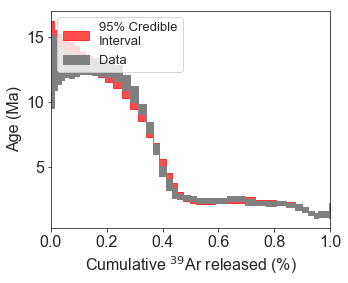

In [306]:
fig = plt.figure(figsize = (5, 4))

plt.fill_between(data2_plot[0:N+1], low2_plot, 
                 high2_plot, 
                 alpha = 0.7, 
                color = 'r', 
                label = '95% Credible\nInterval', 
                step = 'pre')

plt.fill_between(data2_plot, 
                data_plot + 2*age_err_plot, 
                data_plot - 2*age_err_plot, 
                color = 'grey', 
                step = 'pre', 
                label = 'Data')


plt.xlabel('Cumulative $^{39}$Ar released (%)')
plt.ylabel('Age (Ma)')
plt.legend(loc = 2, fontsize = 13)
plt.xlim(0, 1)

In [307]:
tplot = 10000/tempk


In [308]:
N = tplot.shape[0]


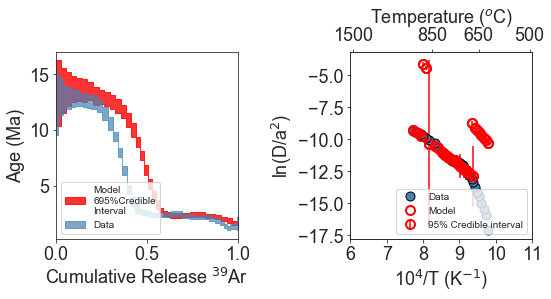

In [309]:
sns.set_style('ticks')

font= {"family": "Arial", 
      "weight": "normal",
      "size":18}

plt.rc("font", **font)




fig, ax = plt.subplots(1,2, figsize = (8, 4.5))

ax[0].fill_between(frel_model_plot, low2_plot, 
                 high2_plot, 
                 alpha = 0.8, 
                color = 'r', 
                label = 'Model\n695%Credible\nInterval', 
                  step = 'pre', 
                  interpolate = True,  
                  lw = 1)


ax[0].fill_between(data2_plot, 
                data_plot + 2*age_err_plot, 
                data_plot - 2*age_err_plot, 
                color = 'steelblue', 
                step = 'pre', 
                label = 'Data' ,
                  alpha = 0.7)

ax[0].set_xlabel('Cumulative Release $^{39}$Ar')
ax[0].set_ylabel('Age (Ma)')




ax[1].plot(tplot[:N], np.log(da2[:N]), 
          'o', markerfacecolor = 'steelblue', 
          markeredgecolor = 'k', 
          markersize = 9, label = 'Data')


ax[1].plot(tplot[0:N],Z1, 'or',
             markerfacecolor = 'None',
            alpha = 1, 
             markeredgecolor = 'r',
           markeredgewidth = 2, 
            markersize = 9, 
            label = 'Model')


ax[1].errorbar(tplot[0:N],Z1, yerr = high1 - low1, 
              color = 'r', 
              fmt = 'o',markerfacecolor = 'None',
            alpha = 1, 
             markeredgecolor = 'r',
           markeredgewidth = 2, 
            markersize = 9, 
              label = '95% Credible interval')


#### Temp #####

ax2 = ax[1].twiny()

Tdc = np.array([500,  650, 850,  1500])
Tp = 10e3/(Tdc + 273.15)
labels = list(['500', '650', '850',   
              '1500'])
ax2.plot(tplot, np.log(da2[:N]), alpha = 0)
ax2.set_xlabel('Temperature ($^{o}$C)')
ax[1].set_xlim(Tp.min() - 0.1, Tp.max()+ 0.3)
ax2.set_xlim(Tp.min() -0.1, Tp.max()+ 0.1)

ax2.set_xlabel('Temperature ($^{o}$C)')
ax2.set_xticks(Tp)
ax2.set_xticklabels(labels)




ax[1].set_xlabel('10$^{4}$/T (K$^{-1}$)')
ax[1].set_ylabel('ln(D/a$^{2}$)')
ax[1].locator_params(axis='y', nbins=6)
ax[1].locator_params(axis='x', nbins=6)



ax[0].set_xlim(0, 1)
ax[1].set_xlim(6, 11)
ax[0].legend(loc = 3, fontsize = 10)
ax[1].legend(loc = 4, fontsize = 10)

plt.tight_layout()
plt.savefig('/Users/jackcarter/Desktop/hb_Acs_test_2.pdf')

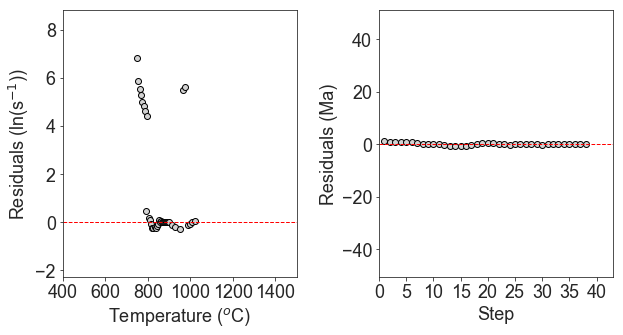

In [310]:
fig, ax = plt.subplots(1,2, figsize = (9,5))


ax[0].plot(tempk[0:N] - 273.15, Z1- np.log(da2[0:N]),
         'ok', 
        markeredgecolor = 'k', 
        markerfacecolor = 'lightgrey')
qqq = Z1 - np.log(da2[0:N])
ax[0].axhline(0, lw = 1, ls = '--', 
           color = 'r')
ax[0].set_ylabel('Residuals (ln(s$^{-1}$))')
ax[0].set_xlabel('Temperature ($^{o}$C)')
ax[0].set_ylim(qqq.min() - 2, qqq.max() + 2)
ax[0].locator_params(axis='x', nbins=6)
ax[0].set_xlim(400, 1500)


ax[1].plot(np.linspace(1, N, N).astype(int), Z2 - age[:N], 'ok', 
        markeredgecolor = 'k', 
        markerfacecolor = 'lightgrey')
qqq2 = Z2 - age[:N]
ax[1].set_ylim(qqq2.min() - 50, qqq2.max() + 50)

ax[1].axhline(0, lw = 1, ls = '--', 
           color = 'r')
ax[1].set_ylabel('Residuals (Ma)')
ax[1].set_xlabel('Step')
ax[1].locator_params(axis='x', nbins=10)
ax[1].set_xlim(0, N+5)

plt.tight_layout()

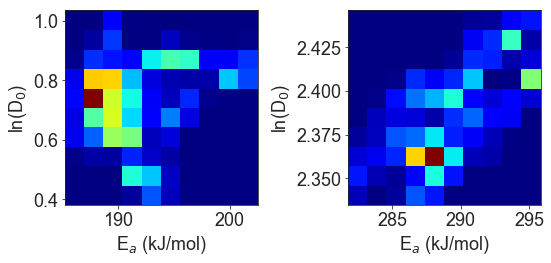

In [311]:
"""
Plot Natural log of D0 vs. EA
Looking for highly 
correlated sampling 
higher Ea
higher D0
"""

fig, ax = plt.subplots(1,2, figsize = (8, 4))

ax[0].hist2d(trace['Ea'][:,0][-SAMPLES:].round(5),
                np.log(trace['d0'][:,0][-SAMPLES:]), 
               cmap = 'jet')
ax[1].hist2d(trace['Ea'][:,1][-SAMPLES:].round(5),
                np.log(trace['d0'][:,1][-SAMPLES:]), 
               cmap = 'jet')


ax[0].set_ylabel('ln(D$_{0}$)')
ax[0].set_xlabel('E$_{a}$ (kJ/mol)')

ax[1].set_ylabel('ln(D$_{0}$)')
ax[1].set_xlabel('E$_{a}$ (kJ/mol)')
#ax[0].ticklabel_format(useOffset=False)
#ax[1].ticklabel_format(useOffset=False)

plt.tight_layout()


In [312]:
df_age = pd.DataFrame({"age_model": Z2,
                      "age_model_low": low2,
                      "age_model_high": high2, 
                      "frel_model": frel_model})

df_arr = pd.DataFrame({"arr_model": Z1,
                      "arr_model_low": low1,
                      "arr_model_high": high1})

df_age_comp = pd.DataFrame({"age1": trace['age_model'][:,0][-SAMPLES:],
                           "age2": trace['age_model'][:,1][-SAMPLES:]})

df_w_comp = pd.DataFrame({"w1": trace['K'][:,0][-SAMPLES:],
                           "w2": trace['K'][:,1][-SAMPLES:]})


df_ea_comp = pd.DataFrame({"ea1": trace['Ea'][:,0][-SAMPLES:],
                           "ea2": trace['Ea'][:,1][-SAMPLES:]})


df_d0_comp = pd.DataFrame({"d01": trace['d0'][:,0][-SAMPLES:],
                           "d02": trace['d0'][:,1][-SAMPLES:]})


In [313]:
df_age.to_csv("/Users/jackcarter/Missoula/Missoula outputs/hbd1_acs_age.csv")
df_arr.to_csv("/Users/jackcarter/Missoula/Missoula outputs/hbd1_acs_arr.csv")
df_age_comp.to_csv("/Users/jackcarter/Missoula/Missoula outputs/hbd1_acs_age_comp.csv")
df_w_comp.to_csv("/Users/jackcarter/Missoula/Missoula outputs/hbd1_acs_w_comp.csv")

df_ea_comp.to_csv("/Users/jackcarter/Missoula/Missoula outputs/hbd1_acs_ea_comp.csv")
df_d0_comp.to_csv("/Users/jackcarter/Missoula/Missoula outputs/hbd1_acs_d0_comp.csv")
